In [2]:
bus_times <- c(14, 15, 38, 13, 12, 8, 4, 15, 13, 31, 16)
to_naha<- c(1,1,0,0,1,1,1,0,0,0,0)

We propose a model

$$
Y_i \sim \text{Exponential}(\mu_i) \\
\mu_i = \beta_1 + \beta_2 \text{Naha}_i
$$

with prior distributions
$$
\beta_1 \sim \text{Gamma}(15,5) \\
\beta_2 \sim \text{Gamma}(0,1)
$$

This gives us the full joint distribution
$$
\log p(\beta_1, \beta_2, \mathbf{Y}) = \sum^{N}_{i=1} \bigg( \log\frac{1}{\sqrt{2 \pi 10^2}} - \frac{1}{2 \times 10^2}(Y_i - \mu_i)^2 \bigg) + \frac{1}{\sqrt{2\pi}} -\frac{1}{2}\beta_1^2 + \frac{1}{\sqrt{2\pi}} -\frac{1}{2}\beta_2^2
$$

If we propose variational distributions
$$
q(\beta_1) \sim \text{Normal}(m_1, s_1) \\
q(\beta_2) \sim \text{Normal}(m_2, s_2)
$$

We begin by setting random values to the variational parameters $(m_1, s_1, m_2, s_2)$

In [3]:
set.seed(923)

param_b1 <- c(
    rnorm(1,15,5),
    rchisq(1,1)
)

param_b2 <- c(
    rnorm(1,0,1),
    rchisq(1,1)
)

rbind(param_b1, param_b2)

param_b1,12.347694871,0.002510467
param_b2,0.008812543,0.875249759


The following code computes the Markov Blanket difference $\log p_{(i)} - \log q_{(i)}$ for $(m_1, s_1)$:

$$
\sum^{N}_{i=1} \bigg( \log\frac{1}{\sqrt{2 \pi 10^2}} - \frac{1}{2 \times 10^2}(Y_i - \mu_i)^2 \bigg) -\frac{1}{2} \beta_1^2 - \log \frac{1}{\sqrt{2\pi s_1^2}} +\frac{(\beta_1 - m_1)^2}{2 s_1^2}
$$

In [129]:
diff1 <- function(b1, b2, m1, s1){
    mu = exp(b1 + b2 * to_naha)
    d = sum(log(mu) - mu * bus_times) - b1^2/2 - log(1/sqrt(2 * pi * s1^2)) + (b1 - m1)^2/(2 * s1^2)
    return(d)
}

diff1(b1=1, b2=1.5, m1=param_b1[1], s1=param_b1[2])

[1] 184850.4

Likewise the following code computes the Markov Blanket difference for $(m_2, s_2)$:

$$
\sum^{N}_{i=1} \bigg( \log\mu_i - \mu_i Y_i \bigg) -\frac{\beta_2^2}{2} - \log \frac{1}{\sqrt{2\pi s_2^2}} -\frac{(\beta_2 - m_2)^2}{2 s_2^2}
$$

In [130]:
diff2 <- function(b1, b2, m2, s2){
    mu = exp(b1 + b2 * to_naha)
    d = sum(log(mu) - mu * bus_times) - b2^2/2 - log(1/sqrt(2 * pi * s2^2)) + (b2 - m2)^2/(2 * s2^2)
    return(d)
}

diff2(b1=1, b2=1.5, m2=param_b2[1], s2=param_b2[2])

[1] -968.5637

And the gradients are given by

$$
\begin{bmatrix}
\frac{\beta_1 - m_1}{s^2_1} & -\frac{1}{2 s^2_1} + \frac{(\beta_1 - m_1)^2}{2 s^4_1} & \frac{\beta_2 - m_2}{s^2_2} & -\frac{1}{2 s^2_2} + \frac{(\beta_2 - m_2)^2}{2 s^4_2}
\end{bmatrix}^T
$$

In [131]:
grads <- function(b1, b2, m1, m2, s1, s2){
    comp1 = (b1 - m1)/s1^2
    comp2 = -1/(2 * s1^2) + (b1 - m1)^2/(2 * s1^4)
    comp3 = (b2 - m2)/s2^2
    comp4 = -1/(2 * s2^2) + (b2 - m2)^2/(2 * s2^4)

    return(c(comp1, comp2, comp3, comp4))
}

grads(1,1,1,1,1,1)

[1]  0.0 -0.5  0.0 -0.5

We now proceed to performing variational inference:

In [252]:
S <- 100000
maxIter <- 10
params <- NULL # matrix for tracking parameter updates

set.seed(923)

param_b1 <- c(
    rnorm(1,0,2),
    rchisq(1,1)
)

param_b2 <- c(
    rnorm(1,0,2),
    rchisq(1,1)
)

for(j in 1:maxIter){
    lgrt <- 0.01

    b1 <- rnorm(S, mean=param_b1[1], sd=param_b1[2])
    b2 <- rnorm(S, mean=param_b2[1], sd=param_b2[2])

    L = sapply(1:S, function(i){
        g = grads(b1[i], b2[i], m1=param_b1[1], m2=param_b2[1], s1=param_b1[2], s2=param_b2[2])
        d = c(
            diff1(b1[i],b2[i],m1=param_b1[1],s1=param_b1[2]),
            diff1(b1[i],b2[i],m1=param_b1[1],s1=param_b1[2]),
            diff2(b1[i],b2[i],m2=param_b2[1],s2=param_b2[2]),
            diff2(b1[i],b2[i],m2=param_b2[1],s2=param_b2[2])
        )

        return(d * g)
    })

    varL = mean(apply(L[,sample(1:S, size=S/3, replace=TRUE)], 1, var))
    meanL = apply(L, 1, mean)

    jsFac = positive(1 - (varL/(S/3))/sum(meanL^2))
    jsL = jsFac * meanL

    oldparams = c(param_b1, param_b2)
    newparams = oldparams + lgrt * jsL

    newparams[1] = newparams[1] * (abs(newparams[2]) < 5)
    newparams[3] = newparams[3] * (abs(newparams[3]) < 5)

    newparams[2] = newparams[2] * (newparams[2] > 0) + 1 * (newparams[2] <= 0)
    newparams[4] = newparams[4] * (newparams[4] > 0) + 1 * (newparams[4] <= 0)

    message(paste0(newparams, sep=", "))

    params <- rbind(params, newparams)

    param_b1 = newparams[1:2]
    param_b2 = newparams[3:4]

    # check for convergence
    diffparams <- sum((newparams - oldparams)^2)/min(1,sum(oldparams^2))
    if(j %% 1 == 0) message(paste0("Iteration ", j, " d=",diffparams, " jsFac=",jsFac))
    #if(diffparams < 0.001) break
}

row.names(params) <- NULL
colnames(params) <- c("m1","s1","m2","s2")


0.001, 700.47743770951, -0.178326215657294, 0.757866416486028, 

Iteration 1 d=490666.30355018 jsFac=0.874527920916293



ERROR: Error in if (x > 0) return(x): missing value where TRUE/FALSE needed


In [223]:
params

m1,s1,m2,s2
-1.060922,0.002510467,0.01762509,0.8752498


In [201]:
positive <- function(arr){
    sapply(arr, function(x){
        if(x > 0) return(x)
        return(0)
    })
}

positive(c(-1,1.1,0.9,1))

[1] 0.0 1.1 0.9 1.0

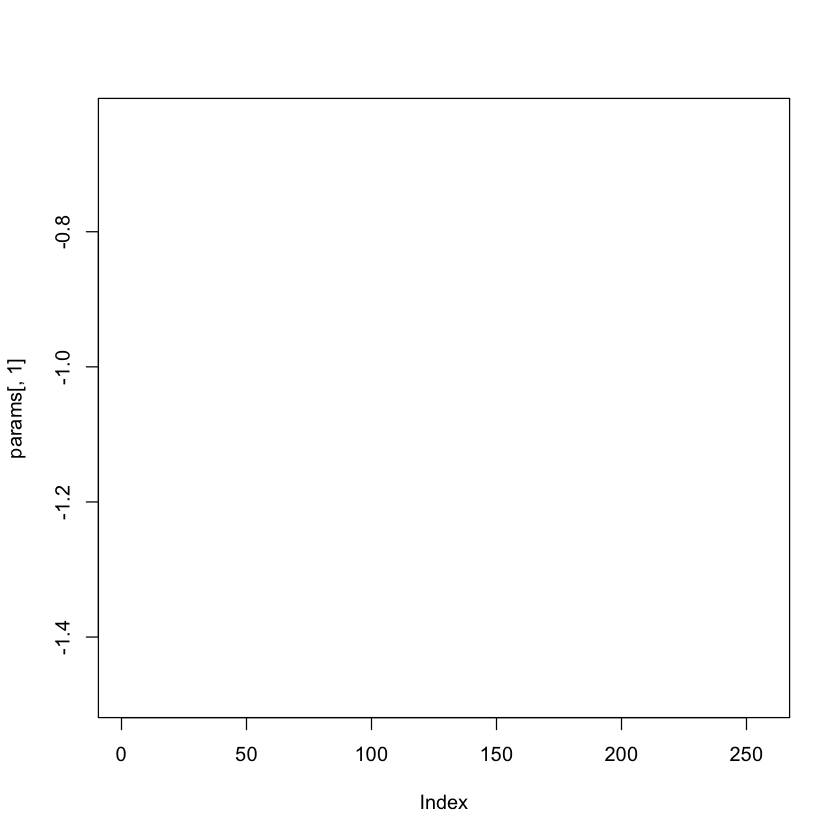

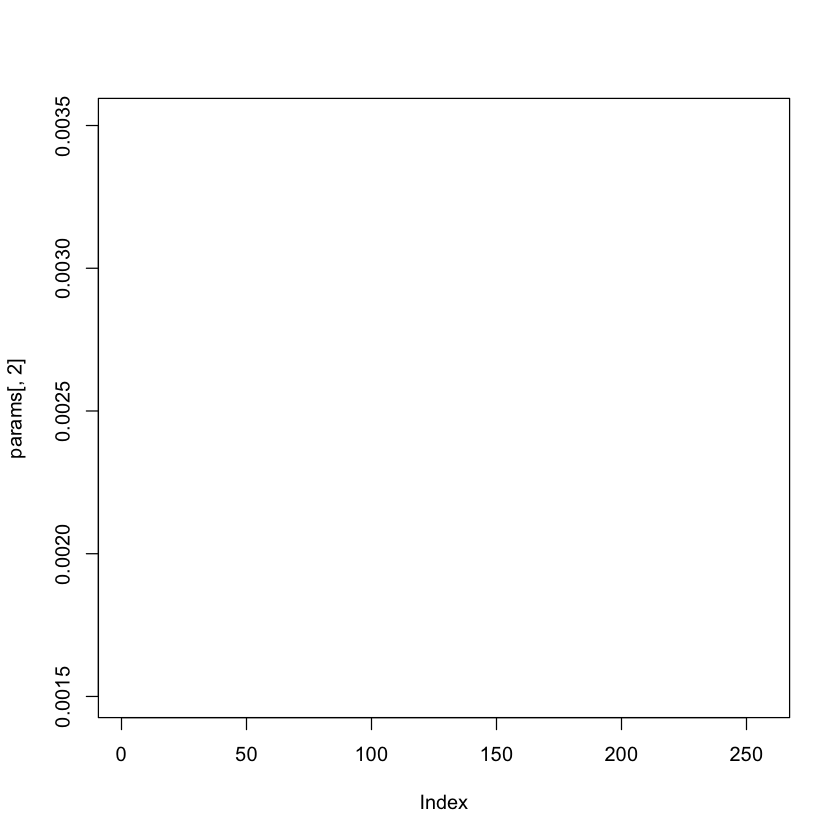

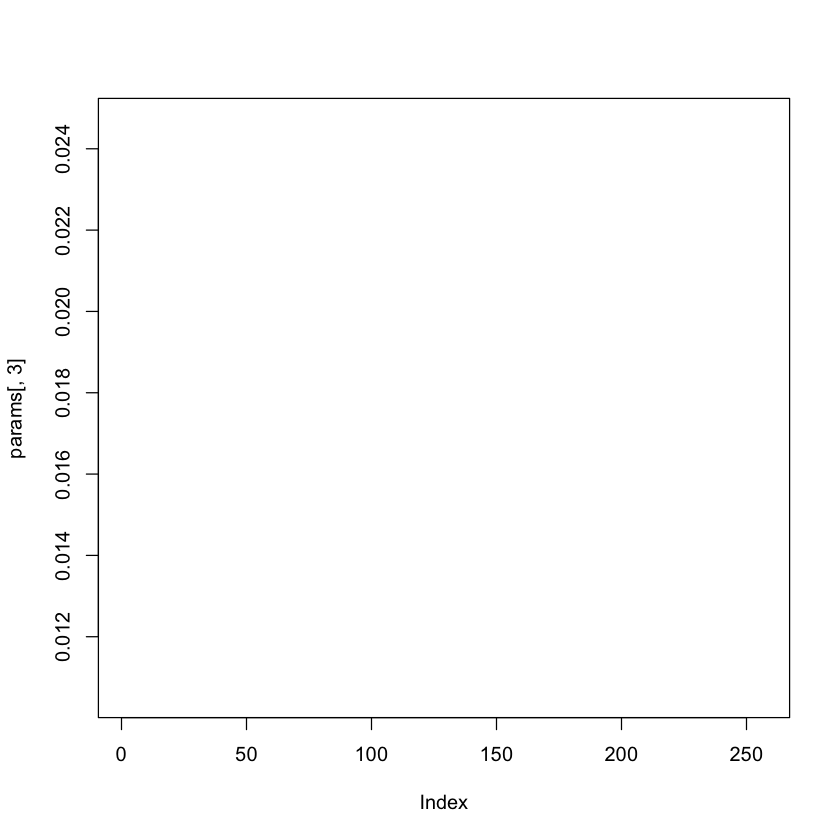

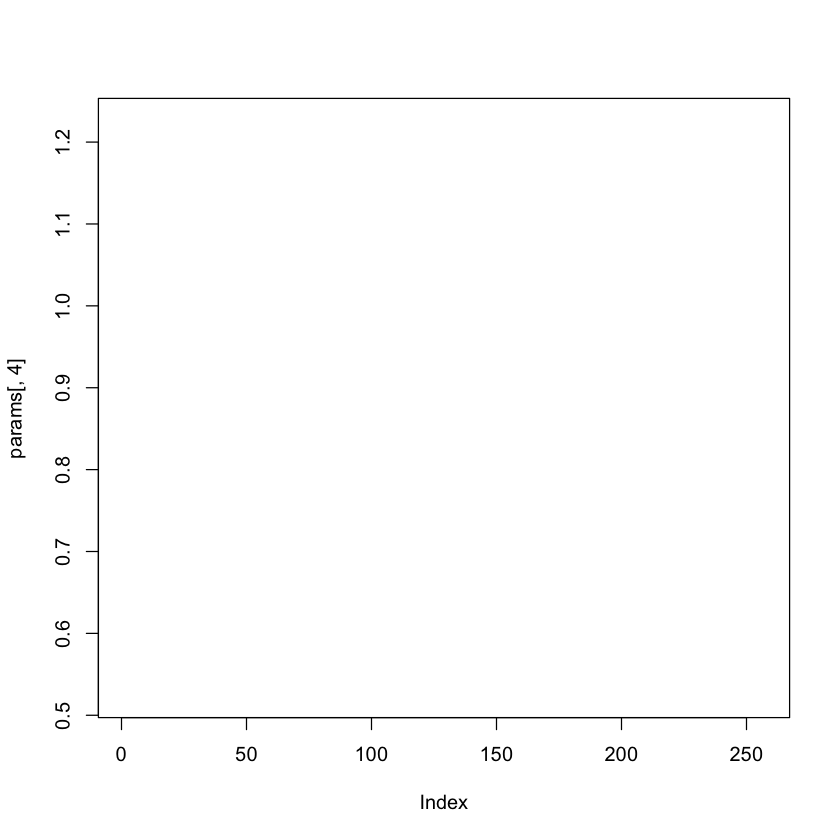

In [225]:
plot(params[,1], type="l", col="white")
plot(params[,2], type="l", col="white")
plot(params[,3], type="l", col="white")
plot(params[,4], type="l", col="white")